# Running Spectral Fitting

Fitting spectral methods on simulated power spectra.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats.mstats import normaltest

from fooof.sim import gen_power_spectrum, gen_group_power_spectra

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.fit import *
from apm.fake import SimFits, print_res
from apm.plts import plot_psds, plot_psds_two
from apm.plts.utils import color_red_or_green

from apm.core.db import APMDB
from apm.core.io import save_pickle, load_pickle

from apm.sim.peaks import *

### Editorial Note

Still some work to do here to check the simulation code and make sure everything is updated properly. 

In [3]:
from apm.sim.peaks import gen_osc_def

### Setup & Settings

In [4]:
# Set up project database object
db = APMDB()

In [5]:
# General simulation settings
f_range = [3, 40]

off_val = 0

noise = 0.0

## Check out PSD generation and test fitting

In [6]:
# Generate a single simulated test power spectrum
exp_val = 1
peaks = gen_osc_def(n_oscs=1)

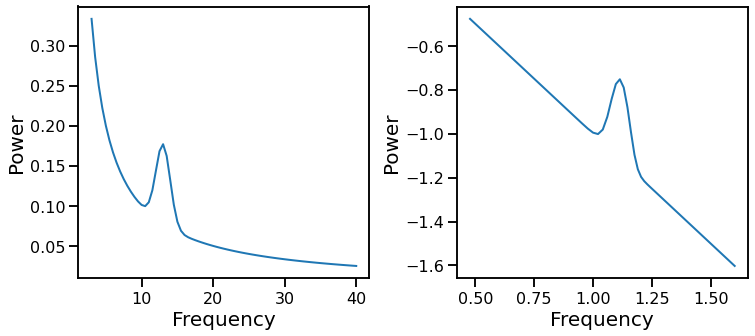

In [7]:
# Old version
fs, psd = sim_psd(f_range, exp_val, peaks, noise)

# Plot and check a simulated spectrum, plotted in semi-log and log space
plot_psds_two(fs, psd, np.log10(fs), np.log10(psd))

In [8]:
# Simulate an example power spectrum
fs, psd = gen_power_spectrum(f_range, [off_val, exp_val], peaks, noise)

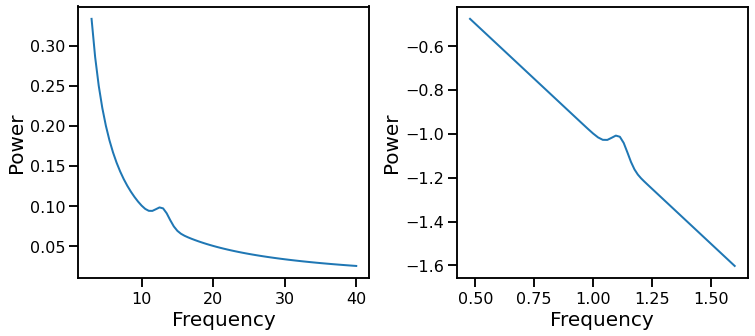

In [9]:
# Plot and check a simulated spectrum, plotted in semi-log and log space
plot_psds_two(fs, psd, np.log10(fs), np.log10(psd))

In [10]:
# Test out fits
print('True exponent value is ', str(exp_val), '\n')
print('OLS fit: \t', fit_ols(fs, psd))
print('RLM fit: \t', fit_rlm(fs, psd))
print('RLM-EA fit: \t', fit_rlm_alph(fs, psd))
print('RLM-EO fit: \t', fit_rlm_oscs(fs, psd))
print('RAN fit: \t', fit_ransac(fs, psd))
print('RAN-EA fit: \t', fit_ransac_alph(fs, psd))
print('RAN-EO fit: \t', fit_ransac_oscs(fs, psd))
print('EXP fit: \t', fit_exp(fs, psd))
print('EXP-EA fit: \t', fit_exp_alph(fs, psd))
print('EXP-EO fit: \t', fit_exp_oscs(fs, psd))
print('FOOOF fit: \t', fit_fooof(fs, psd))

True exponent value is  1 

OLS fit: 	 -1.0117367296031152
RLM fit: 	 -1.0000000523321662
RLM-EA fit: 	 -1.000000000000052
RLM-EO fit: 	 -1.0000000003983969
RAN fit: 	 -1.0117367296031152
RAN-EA fit: 	 -1.0015731923538589
RAN-EO fit: 	 -1.0010575167451419
EXP fit: 	 -1.0117367288343233
EXP-EA fit: 	 -1.0015731913482473
EXP-EO fit: 	 -1.0010575160077315
FOOOF fit: 	 -1.0000585911502897


## Run a Fits on Simulated Power Spectra

In [11]:
# Settings
n_psds = 50
f_range = [3, 40]
exp_val = 1
noise = 0.05

In [12]:
# NEW VERSION.
freqs, psds, sim_params = gen_group_power_spectra(\
    n_psds, f_range, [off_val, exp_val], gen_osc_def(n_oscs=1), noise, return_params=True)

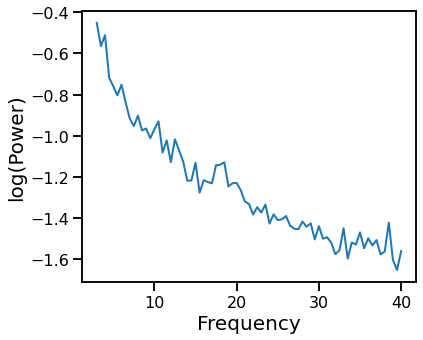

In [13]:
# Plot example simulated power spectrum from the group
plot_psds(freqs, psds[10, :])

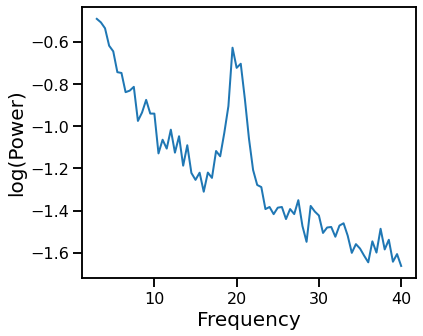

In [14]:
# OLD: Simulate a group of PSDs
freqs, psds = sim_n_psds(n_psds, f_range, exp_val, gen_osc_def, noise)
plot_psds(freqs, psds[:, 10])

In [15]:
# # Check out some of the simulated power spectra
# for ind, psd in enumerate(psds.T):
#     if ind < 5:
#         plt.figure()
#         plt.plot(freqs, psd)

In [16]:
# Initialize and set up for simulated data testing
sims = SimFits()
sims.get_fit_funcs()

In [17]:
# Check the fitting functions being used
print(list(sims.fit_funcs.keys()))

['OLS', 'OLS-EA', 'OLS-EO', 'RLM', 'RLM-EA', 'RLM-EO', 'RAN', 'RAN-EA', 'RAN-EO', 'EXP', 'EXP-EA', 'EXP-EO', 'FOOOF']


In [18]:
# Fit spectra: this fits all methods
sims.fit_spectra(exp_val, freqs, psds)

In [19]:
# Calculate metrics
avgs = sims.calc_avg_errs()
perc_good = sims.calc_perc_good()

In [20]:
# Check errors per fitting method
print('AVERAGE FIT ERRORS')
print_res(avgs)

AVERAGE FIT ERRORS
   RLM-EO   		 0.02145
   FOOOF    		 0.02252
   OLS-EO   		 0.02426
   EXP-EO   		 0.02426
   RLM-EA   		 0.02440
   RLM      		 0.02569
   RAN-EO   		 0.02580
   RAN      		 0.02735
   RAN-EA   		 0.02922
   OLS-EA   		 0.02967
   EXP-EA   		 0.02967
   EXP      		 0.03946
   OLS      		 0.03946


In [21]:
# Check errors per fitting method
print('PERCENTAGE FITS BELOW ERROR THRESHOLD')
print_res(perc_good)

PERCENTAGE FITS BELOW ERROR THRESHOLD
   RLM-EO   		 0.58000
   FOOOF    		 0.54000
   RLM-EA   		 0.52000
   OLS-EO   		 0.52000
   EXP-EO   		 0.52000
   RLM      		 0.50000
   RAN-EO   		 0.50000
   RAN      		 0.48000
   OLS-EA   		 0.46000
   EXP-EA   		 0.46000
   RAN-EA   		 0.42000
   OLS      		 0.40000
   EXP      		 0.40000


In [22]:
df = pd.DataFrame(sims.errs)

In [23]:
# Check the correlation structure between fit erros
df.corr()

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.812398,0.443711,0.910781,0.753205,0.418125,0.498985,0.097756,0.391037,1.000000,0.812398,0.443711,0.556834
OLS-EA,0.812398,1.000000,0.574116,0.777322,0.942585,0.539727,0.333044,0.099338,0.450650,0.812398,1.000000,0.574116,0.666400
OLS-EO,0.443711,0.574116,1.000000,0.644284,0.716199,0.979590,0.223686,-0.008342,0.741579,0.443711,0.574116,1.000000,0.817446
RLM,0.910781,0.777322,0.644284,1.000000,0.812889,0.625064,0.533109,0.107075,0.560522,0.910781,0.777322,0.644284,0.736255
RLM-EA,0.753205,0.942585,0.716199,0.812889,1.000000,0.694807,0.278498,0.100313,0.562150,0.753205,0.942585,0.716199,0.776763
RLM-EO,0.418125,0.539727,0.979590,0.625064,0.694807,1.000000,0.220090,-0.014973,0.715044,0.418125,0.539727,0.979590,0.768913
RAN,0.498985,0.333044,0.223686,0.533109,0.278498,0.220090,1.000000,0.086264,0.354139,0.498985,0.333044,0.223686,0.256356
RAN-EA,0.097756,0.099338,-0.008342,0.107075,0.100313,-0.014973,0.086264,1.000000,-0.053880,0.097756,0.099338,-0.008342,0.039577
RAN-EO,0.391037,0.450650,0.741579,0.560522,0.562150,0.715044,0.354139,-0.053880,1.000000,0.391037,0.450650,0.741579,0.593810
EXP,1.000000,0.812398,0.443711,0.910781,0.753205,0.418125,0.498985,0.097756,0.391037,1.000000,0.812398,0.443711,0.556834


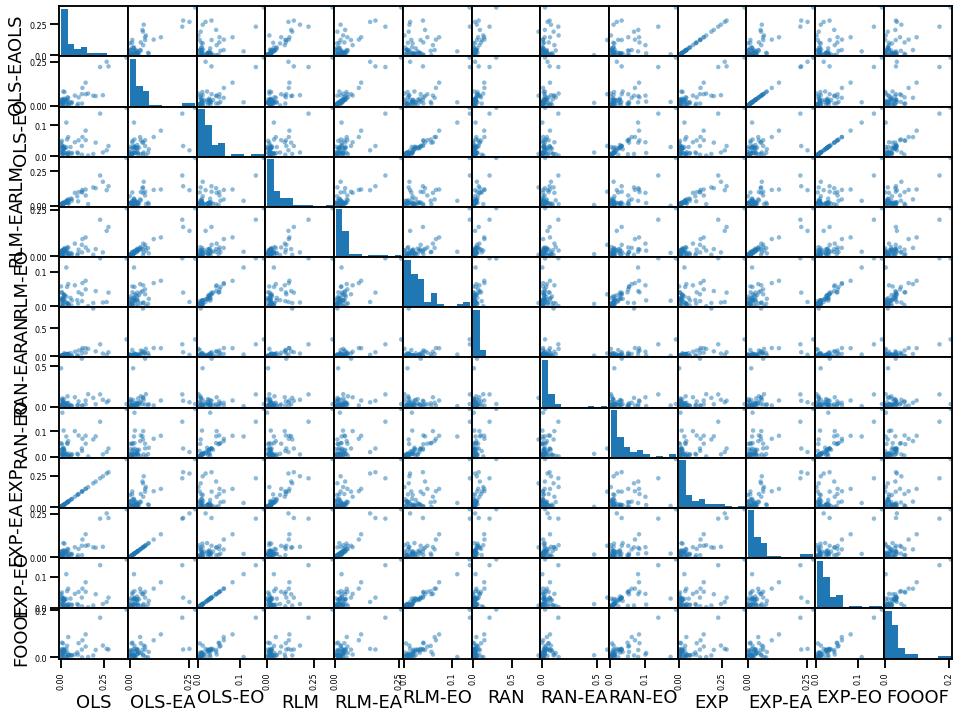

In [24]:
# Plot data distributions and inter-relations
pd.plotting.scatter_matrix(df, figsize=[16, 12]);

In [25]:
# Apply a normal test across fit-error distributions
normalities = df.apply(normaltest)

# Check which results of normal test
nt_df = pd.DataFrame([data[1] for data in normalities.values], index=normalities.index)
nt_df.style.applymap(color_red_or_green)

,0
0,38.140131
1,0.000000


In [26]:
# Save out simulated fit data to pickle
save_pickle(sims.errs, 'SimFits_test.p', db.sims_path)

In [27]:
# Check available simulated fit results files
sim_files = db.check_files('sims')
f_ind = sim_files.index('SimFits_test.p')

In [28]:
# Load simulated fit results data from pickle file
data = load_pickle(sim_files[f_ind], db.sims_path)
sim_dat = SimFits()
sim_dat.errs = data